**Preparing the data and developing the model**

Impact of the Frequency of Camps and Target Inventory on Shortage and Wastage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
main_df = pd.read_csv("Assignment8-Data.csv")

In [3]:
main_df.columns

Index(['S.No.', 'Daily Demand for the Perishable Item (Units)',
       'Supply Quantity Per Camp for the Perishable Item (Units)'],
      dtype='object')

In [4]:
main_df = main_df.rename(mapper={main_df.columns[0]:"id",
                                 main_df.columns[1]:"demand",
                                 main_df.columns[2]:"supply"},
                         axis="columns")
main_df.describe()

,id,demand,supply
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,27.851000,77.972200
std,2886.89568,5.292504,34.546629
min,1.00000,9.000000,32.000000
25%,2500.75000,24.000000,53.000000
50%,5000.50000,28.000000,72.000000
75%,7500.25000,31.000000,89.000000
max,10000.00000,48.000000,223.000000


MBB is interested in analyzing the impact of different policies on the platelets’ shortage and wastage. Suppose
that the shelf life of platelets is seven days, the target inventory is 1400, and the donation camps are held daily.
For both supply and demand, 10,000 random observations are provided in Data.xlsx file.

In [5]:
# Shelf life of platelets
shelf_life = 7

# Target inventory
tar_inv = 1400

ndays = 10000

# Donation camps are held daily

A poisson distribution is fit on demand data, and the poisson's parameter of the fit is obtained to generate more new random data for demand.

In [6]:
# demand_fit = stats.fit(dist=stats.poisson, data=main_df["demand"], bounds=[(0,100)])
# demand_fit.params
# np.random.seed(0)
# demand = stats.poisson.rvs(demand_fit.params[0], loc=demand_fit.params[1], size=ndays)
demand = main_df.demand

For supply data, the probability of each value is obtained and based on that new random data of similar distribution is generated for supply.

In [7]:
# df = main_df.groupby(by="supply").supply.count()/len(main_df)
# supply_values = df.index
# probabilities = df.values
# supply = np.random.choice(a=supply_values, p=probabilities, size=ndays)
supply = main_df.supply

In [8]:

def solve_MBB(tar_inv, shelf_life, supply, demand):
    shortage = np.zeros(ndays)
    wastage = np.zeros(ndays)
    inv_arr = np.zeros(shape=(ndays, shelf_life))
    
    # Replenishing the inventory for the first day
    inv_arr[0,0] = min(supply[0], max(tar_inv-sum(inv_arr[0,1:]), 0))
    
    for i in range(1, ndays):
        for j in range(1, shelf_life):
            inv_arr[i,j] = max(inv_arr[i-1, j-1]-
                               max(demand[i-1]-sum(inv_arr[i-1,j:shelf_life]),0),0)

        # Adding new supply to inventory based on available inventory
        inv_arr[i,0] = min(supply[i], max(tar_inv-sum(inv_arr[i,1:]), 0))
        
        shortage[i] = max(demand[i]-sum(inv_arr[i,:]),0)
        wastage[i] = max(inv_arr[i,-1]-demand[i],0)
    return inv_arr, shortage, wastage

# Target inventory effect

Assuming that the target inventory is decreased to 200 units the daily average wastage and shortage for the blood bank is obtained:

In [9]:
inv, shortage, wastage = solve_MBB(200, shelf_life, supply, demand)

In [10]:
np.average(shortage)

0.0

In [11]:
np.average(wastage)

1.6785

In [12]:
# inv
np.savetxt("inv.csv", inv, delimiter=",")

# Decreasing donation camps' duration

MBB is considering decreasing the donation camp’s duration, which leads to less supply for each period.
Reducing the supply for each period by 15%, 25%, 35%, ... ,85%, 95%, the average
shortage and wastage change as presented below:

In [13]:
reductions = np.arange(0.15, 1.05, 0.1)
shortage_avgs = np.zeros(len(reductions))
wastage_avgs = np.zeros(len(reductions))

for idx, portion in enumerate(reductions):
    red_supply = supply * (1-portion)
    inv, shortage, wastage = solve_MBB(200, shelf_life, red_supply, demand)
    shortage_avgs[idx] = np.floor(np.average(shortage))
    wastage_avgs[idx] = np.floor(np.average(wastage))

Text(0, 0.5, 'Value')

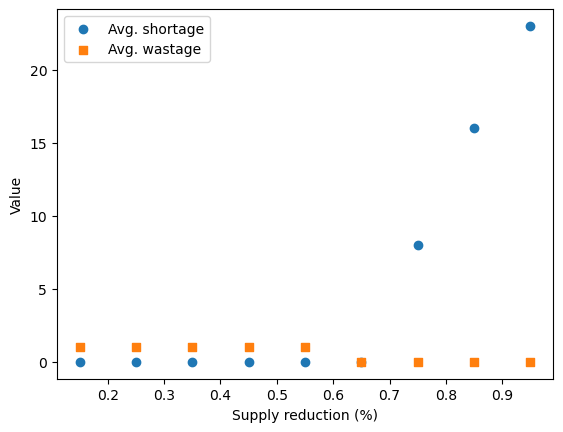

In [14]:
fig, ax = plt.subplots()
ax.scatter(x=reductions, y=shortage_avgs, marker="o", label="Avg. shortage")
ax.scatter(x=reductions, y=wastage_avgs, marker="s", label="Avg. wastage")
ax.legend()
ax.set_xlabel("Supply reduction (%)")
ax.set_ylabel("Value")

The plot above shows that as the average wastage becomes zero the average shortage starts to increase from zero, but as far as average wastage exist there is no considerable average shortage.

In [15]:
df_out = pd.DataFrame((reductions, shortage_avgs, wastage_avgs))
df_out = df_out.transpose()
df_out.columns = (("Recution rate", "Average shortage", "Average wastage"))
print(df_out)

   Recution rate  Average shortage  Average wastage
0           0.15               0.0              1.0
1           0.25               0.0              1.0
2           0.35               0.0              1.0
3           0.45               0.0              1.0
4           0.55               0.0              1.0
5           0.65               0.0              0.0
6           0.75               8.0              0.0
7           0.85              16.0              0.0
8           0.95              23.0              0.0


# Decreasing donation camps' frequency

MBB is willing to examine the impact of decreasing the frequency of donation camps on the percentage of wastage and shortage if the donation camps were held:
* every two days instead of every day
* every three days instead of every day

To determine the supply for each day when the frequency is decreased to “every two days”, it is assumed that the supply of day i (i = 1, 3, 5, . . . ) is equal to the supply of day i plus the supply of day i+1.
Similarly, the supply can be determined for “every three days” case.

## Case 1: supply at every two days

In [19]:
new_supply_1 = np.zeros(ndays)

# Modify supply values based on the 1st scenario
for idx, sup in enumerate(supply):
    if (idx%2 == 0) and (idx <= ndays-2):
        new_supply_1[idx] = supply[idx] + supply[idx+1]
    else:
        new_supply_1[idx] = 0
        
# Obtain inventory, shortage and wastage values
inv, shortage, wastage = solve_MBB(200, shelf_life, new_supply_1, demand)
shortage_rate = np.sum(shortage)/np.sum(new_supply_1)*100
wastage_rate = np.sum(wastage)/np.sum(new_supply_1)*100
print("Shortage rate: {:.2f}%".format(shortage_rate))
print("Wastage rate: {:.2f}%".format(wastage_rate))

Shortage rate: 0.00%
Wastage rate: 1.88%


## Case 2: supply at every three days

In [17]:
new_supply_2 = np.zeros(ndays)

# Modify supply values based on the 2nd scenario
for idx, sup in enumerate(supply):
    if (idx%3 == 0) and (idx <= ndays-3):
        new_supply_2[idx] = supply[idx] + supply[idx+1] + supply[idx+2]
    else:
        new_supply_2[idx] = 0

# Obtain inventory, shortage and wastage values
inv, shortage, wastage = solve_MBB(200, shelf_life, new_supply_2, demand)
shortage_rate = np.sum(shortage)/np.sum(new_supply_2)*100
wastage_rate = np.sum(wastage)/np.sum(new_supply_2)*100
print("Shortage rate: {:.2f}%".format(shortage_rate))
print("Wastage rate: {:.2f}%".format(wastage_rate))

Shortage rate: 0.00%
Wastage rate: 1.67%


## The effect of reducing the frequency of donation camps: